In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor

In [2]:
# 1. 讀取資料
train = pd.read_csv('bike-sharing-demand/train.csv')

# train_X = train[['temp', 'atemp']].values
# train_y = train['count'].values


In [4]:
# 2. 處理時間類型資料
train['datetime'] = pd.to_datetime(train['datetime'])

train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day_of_month'] = train['datetime'].dt.day
train['day_of_week'] = train['datetime'].dt.day_of_week
train['hour'] = train['datetime'].dt.hour
print(train.columns)

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day_of_month', 'day_of_week', 'hour'],
      dtype='object')


(10739, 17)


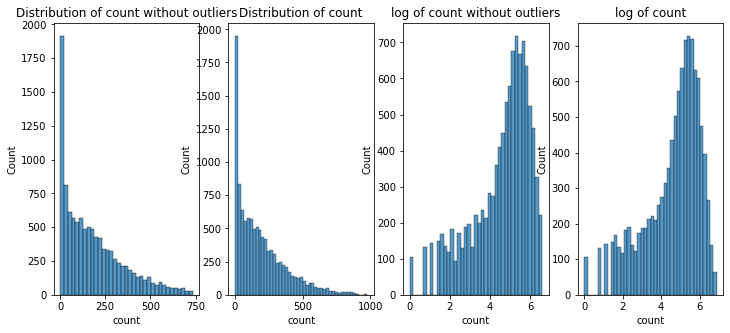

train_WithoutOutliers 1.0283436063589986 0.42340096046253795
train 1.2420662117180776 1.3000929518398334
train_WithoutOutliers_log -0.9901649212433088 0.2509769873697447
train_log -0.9712277227866112 0.24662183416964112


In [5]:
# *target 分布分析
train_WithoutOutliers = train[np.abs(train['count'] -
                                     train['count'].mean()) <= (3 * train['count'].std())]
print(train_WithoutOutliers.shape)

fig = plt.figure()
ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)
fig.set_size_inches(12, 5)

sns.histplot(train_WithoutOutliers['count'], ax=ax1)
sns.histplot(train['count'], ax=ax2)
sns.histplot(np.log(train_WithoutOutliers['count']), ax=ax3)
sns.histplot(np.log(train['count']), ax=ax4)

ax1.set(xlabel='count', title='Distribution of count without outliers')
ax2.set(xlabel='count', title='Distribution of count')
ax3.set(xlabel='count', title='log of count without outliers')
ax4.set(xlabel='count', title='log of count')
plt.show()

print('train_WithoutOutliers', train_WithoutOutliers['count'].skew(), train_WithoutOutliers['count'].kurt())
print('train', train['count'].skew(), train['count'].kurt())
print('train_WithoutOutliers_log', np.log(train_WithoutOutliers['count']).skew(),
      np.log(train_WithoutOutliers['count']).kurt())
print('train_log', np.log(train['count']).skew(), np.log(train['count']).kurt())

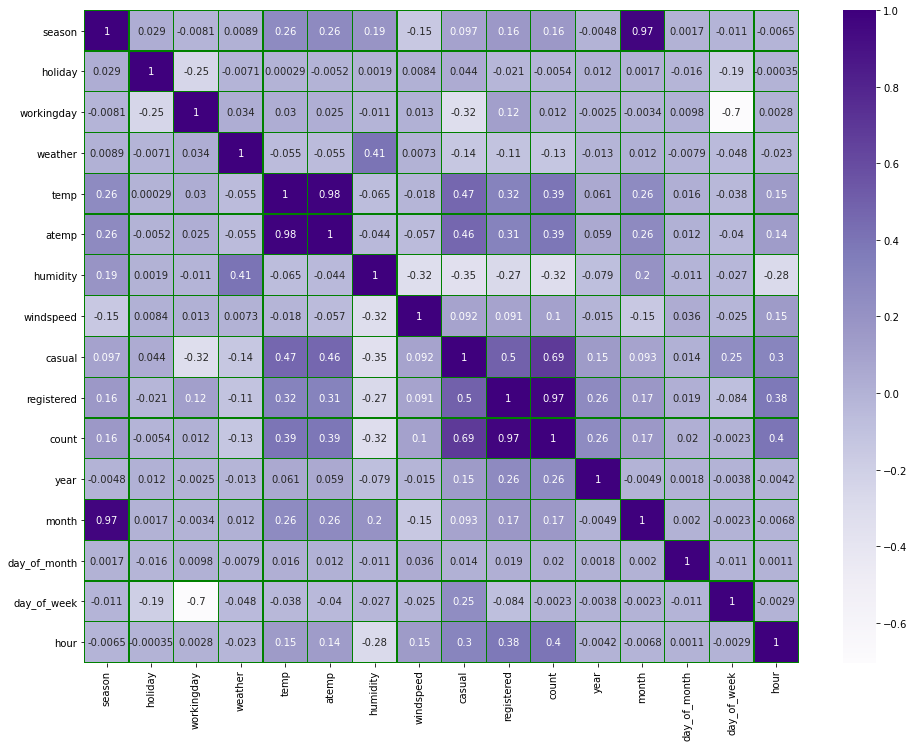

humidity       -0.317371
weather        -0.128655
holiday        -0.005393
day_of_week    -0.002283
workingday      0.011594
day_of_month    0.019826
windspeed       0.101369
season          0.163439
month           0.166862
year            0.260403
atemp           0.389784
temp            0.394454
hour            0.400601
casual          0.690414
registered      0.970948
count           1.000000
Name: count, dtype: float64


In [9]:
# 3. 觀察特徵值相關性
train_y = np.log(train['count'])
plt.figure(figsize=(16,12))
sns.heatmap(train.corr(), cmap='Purples', annot=True, linecolor='Green', linewidths=0.2)
plt.show()
print(train.corr()['count'].sort_values())

In [10]:
# 4. 切割訓練資料
drop_list = ['datetime', 'casual', 'registered', 'count']
train.drop(drop_list, axis=1, inplace=True)
print(train.columns)
x_train, x_test, y_train, y_test = train_test_split(train, train_y, test_size=0.2, random_state=1)
print('x train :', x_train.shape, '\t\tx test :', x_test.shape)
print('y train :', y_train.shape, '\t\ty test :', y_test.shape)

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'day_of_month', 'day_of_week',
       'hour'],
      dtype='object')
x train : (8708, 13) 		x test : (2178, 13)
y train : (8708,) 		y test : (2178,)


In [14]:
# 5. 特徵值標準化
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
print(x_train.shape,x_test.shape)

(8708, 13) (2178, 13)


In [17]:
# 6. 使用模型
degree = 2
model_list = [('LinearRegression', LinearRegression()), ('KNN', KNeighborsRegressor(n_neighbors=4)),
              ('DecisionTree', DecisionTreeRegressor(random_state=1)),
              ('RandomForest', RandomForestRegressor(random_state=1, n_estimators=10))]
# 評估效能
def mt(mtlist, name, y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    r2s = metrics.r2_score(y_test, y_pred)
    me = metrics.max_error(y_test, y_pred)
    matric = [name, mae, mse, r2s, me]
    mtlist.append(matric)
mt_list = []

poly = PolynomialFeatures(degree=2)
x_train_qua = poly.fit_transform(x_train)
qua = LinearRegression()
qua.fit(x_train_qua, y_train)
y_pred = qua.predict(poly.fit_transform(x_test))
mt(mt_list, 'poly', y_test, y_pred)

for name in model_list:
    model = name[1]
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mt(mt_list, name[0], y_test, y_pred)

mt_df = pd.DataFrame(mt_list, columns=['name', 'mae', 'mse', 'r2s', 'me'])
print(mt_df)

               name       mae       mse       r2s        me
0              poly  0.656459  0.834949  0.626876  3.341553
1  LinearRegression  0.839204  1.161175  0.481091  3.917802
2               KNN  0.643547  0.872700  0.610006  4.397771
3      DecisionTree  0.292782  0.215769  0.903577  2.995732
4      RandomForest  0.228925  0.129606  0.942081  2.501281


              name       mae       mse       r2s        me
0   RandomForest10  0.228925  0.129606  0.942081  2.501281
1   RandomForest11  0.226832  0.126725  0.943369  2.476946
2   RandomForest12  0.227043  0.126675  0.943391  2.482115
3   RandomForest13  0.225838  0.124548  0.944342  2.480163
4   RandomForest14  0.224984  0.122961  0.945051  2.494835
5   RandomForest15  0.223581  0.122254  0.945367  2.477419
6   RandomForest16  0.222408  0.121459  0.945722  2.506608
7   RandomForest17  0.221690  0.121014  0.945921  2.517135
8   RandomForest18  0.221462  0.121154  0.945858  2.535774
9   RandomForest19  0.221530  0.121454  0.945724  2.519870
10  RandomForest20  0.220813  0.121079  0.945892  2.516713
11  RandomForest21  0.221006  0.121295  0.945795  2.513857
12  RandomForest22  0.220012  0.120755  0.946037  2.501118
13  RandomForest23  0.219700  0.120979  0.945937  2.528699
14  RandomForest24  0.219872  0.121688  0.945620  2.542868
15  RandomForest25  0.219552  0.121434  0.945733  2.5243

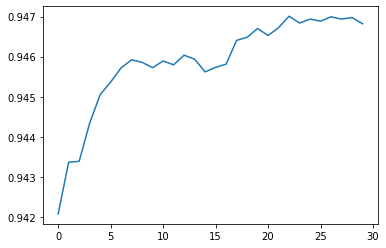

0.947006468190786
22
              name       mae       mse       r2s        me
22  RandomForest32  0.216898  0.118585  0.947006  2.537974


In [25]:
# 驗證參數
mt_list2 = []
for i in range(10, 40):
    model = RandomForestRegressor(random_state=1, n_estimators=i)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mt(mt_list2, 'RandomForest' + str(i), y_test, y_pred)

mt_df2 = pd.DataFrame(mt_list2, columns=['name', 'mae', 'mse', 'r2s', 'me'])
print(mt_df2)

plt.plot(mt_df2['r2s'])
plt.show()

print(mt_df2['r2s'].max())
print(np.argmax(mt_df2['r2s']))
print(mt_df2[22:23])

In [26]:
# 7. 準備test資料
test = pd.read_csv('bike-sharing-demand/test.csv')

test['datetime'] = pd.to_datetime(test['datetime'])
times = test['datetime']

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day_of_month'] = test['datetime'].dt.day
test['day_of_week'] = test['datetime'].dt.day_of_week
test['hour'] = test['datetime'].dt.hour

drop_list = ['datetime']
test.drop(drop_list, axis=1, inplace=True)
test.head(3)

sc = StandardScaler()
x_test = sc.fit_transform(test)

In [27]:
# 7. 確認最優模型後預測
model = RandomForestRegressor(random_state=1, n_estimators=31)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(y_pred[:5])
print([max(0, x) for x in np.exp(y_pred)][:5])

# 8. 格式化後輸出
Submission = pd.DataFrame({'datetime': times, 'count': [max(0, x) for x in np.exp(y_pred)]})
print(Submission.head())
Submission.to_csv('Submission1-2.csv')

Submission.set_index('datetime', inplace=True)
print(Submission.head())
Submission.to_csv('Submission.csv-2')

[2.08573444 1.43202933 1.16613919 0.77237333 0.60674324]
[8.05050195244388, 4.187187759924904, 3.2095771130719215, 2.164898185225247, 1.8344473017824994]
             datetime     count
0 2011-01-20 00:00:00  8.050502
1 2011-01-20 01:00:00  4.187188
2 2011-01-20 02:00:00  3.209577
3 2011-01-20 03:00:00  2.164898
4 2011-01-20 04:00:00  1.834447
                        count
datetime                     
2011-01-20 00:00:00  8.050502
2011-01-20 01:00:00  4.187188
2011-01-20 02:00:00  3.209577
2011-01-20 03:00:00  2.164898
2011-01-20 04:00:00  1.834447
